# **TP2**

##*Organización de Datos (75.06/95.58) - Primer Cuatrimestre 2021*

###### Julio de 2021
---

In [ ]:
# Importamos librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
# Importamos los archivos de entrada desde google drive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/1d3bvCoox6nxGIWx81EMEQl_hJ1Y0Jp1q/view?usp=sharing' 
  
# to get the id part of the file
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train_values.csv')

train_values=pd.read_csv('train_values.csv', index_col='building_id')

In [ ]:
link = 'https://drive.google.com/file/d/1zsOf_CScGSl6O2CBbgQUX7TH3CALpXbl/view?usp=sharing' 
  
# to get the id part of the file
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train_labels.csv')

train_labels=pd.read_csv('train_labels.csv', index_col='building_id')

#Damage grade:
#1 - Low damage
#2 - Medium damage
#3 - Serious damage


In [ ]:
# for preprocessing the data
from sklearn.preprocessing import StandardScaler

# the model
from sklearn.ensemble import RandomForestClassifier

# for combining the preprocess with model training
from sklearn.pipeline import make_pipeline

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV

#metric
from sklearn.metrics import f1_score

In [ ]:
train_values.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
cat_cols=['land_surface_condition','foundation_type','roof_type','ground_floor_type','other_floor_type',
          'position','plan_configuration','legal_ownership_status','geo_level_1_id','geo_level_2_id','geo_level_3_id']
for cc in cat_cols:
    train_values[cc]=train_values[cc].astype('category')

In [ ]:
X_dev = train_values

Y_dev = train_labels['damage_grade'].astype('category')

Y_dev

building_id
802906    3
28830     2
94947     3
590882    2
201944    3
         ..
688636    2
669485    3
602512    3
151409    2
747594    3
Name: damage_grade, Length: 260601, dtype: category
Categories (3, int64): [1, 2, 3]

In [ ]:
from sklearn.model_selection import train_test_split

seed=2

valsize=0.25
X_train, X_val, Y_train, Y_val = train_test_split(X_dev, Y_dev, test_size=valsize, random_state=seed)

# Random Forest

# Set S1:

In [ ]:
#Numericas
X_train_num=X_train.select_dtypes(exclude='category')
X_train_num=X_train_num[X_train_num.columns.drop(list(X_train_num.filter(like='geo_level')))]
X_train_num=X_train_num[X_train_num.columns.drop(list(X_train_num.filter(like='has_')))]
col1=X_train_num.columns.tolist()

#El resto
col2=X_train.filter(like='type').columns.tolist()
col3=['has_superstructure_mud_mortar_stone','has_superstructure_cement_mortar_brick','has_superstructure_rc_engineered','has_superstructure_rc_non_engineered']
cols=col1+col2+col3+['geo_level_1_id']

In [ ]:
X_train_subset = X_train[cols]
X_val_subset = X_val[cols]

#Drop count_floors
X_train_subset = X_train_subset.drop(columns=['count_floors_pre_eq'])
X_val_subset = X_val_subset.drop(columns=['count_floors_pre_eq'])

X_train_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 13 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   age                                     195450 non-null  int64   
 1   area_percentage                         195450 non-null  int64   
 2   height_percentage                       195450 non-null  int64   
 3   count_families                          195450 non-null  int64   
 4   foundation_type                         195450 non-null  category
 5   roof_type                               195450 non-null  category
 6   ground_floor_type                       195450 non-null  category
 7   other_floor_type                        195450 non-null  category
 8   has_superstructure_mud_mortar_stone     195450 non-null  int64   
 9   has_superstructure_cement_mortar_brick  195450 non-null  int64   
 10  has_superstructure_rc_engin

## Encodeamos geolevel1

In [ ]:
df_0=X_train_subset.merge(Y_train, left_index=True, right_index=True, how='inner')
df=df_0[['damage_grade','geo_level_1_id']].copy().set_index(['damage_grade','geo_level_1_id'])
df['countingindex']=1
df=df.groupby(['damage_grade','geo_level_1_id']).agg({'countingindex':'sum'}).unstack().droplevel(0,axis=1).fillna(0)
df

geo_level_1_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
damage_grade,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,246.0,325.0,57.0,184.0,384.0,347.0,1566.0,778.0,489.0,422.0,928.0,279.0,149.0,1453.0,146.0,118.0,146.0,217.0,50.0,33.0,2523.0,239.0,571.0,56.0,202.0,361.0,6054.0,356.0,0.0,7.0,186.0
2,2288.0,1490.0,467.0,3408.0,8299.0,1535.0,12203.0,8557.0,6415.0,2060.0,9104.0,3487.0,1701.0,4650.0,967.0,1286.0,2448.0,2939.0,583.0,182.0,8885.0,4392.0,3415.0,580.0,664.0,3263.0,9452.0,4557.0,112.0,255.0,1594.0
3,445.0,223.0,181.0,2051.0,2143.0,171.0,4562.0,5048.0,7384.0,497.0,6544.0,2375.0,518.0,1005.0,197.0,356.0,711.0,13232.0,1762.0,49.0,1523.0,6528.0,624.0,205.0,91.0,580.0,1484.0,4517.0,74.0,28.0,232.0


In [ ]:
frac_df=np.divide(np.array(df.iloc[0]),np.array(df.sum(axis=0)))
frac_df=pd.concat([pd.Series(frac_df), pd.Series(np.divide(np.array(df.iloc[1]),np.array(df.sum(axis=0))))],axis=1,keys=['1','2'])
frac_df=pd.concat([frac_df, pd.Series(np.divide(np.array(df.iloc[2]),np.array(df.sum(axis=0))))],axis=1)
frac_df=frac_df.rename(columns={0:'3'})
frac_df

,1,2,3
0,0.082578,0.768043,0.149379
1,0.159470,0.731109,0.109421
2,0.080851,0.662411,0.256738
3,0.032607,0.603934,0.363459
4,0.035470,0.766580,0.197949
5,0.169021,0.747686,0.083293
6,0.085429,0.665703,0.248868
7,0.054092,0.594938,0.350970
8,0.034225,0.448978,0.516797
9,0.141658,0.691507,0.166835


In [ ]:
X_train_subset.head()

,age,area_percentage,height_percentage,count_families,foundation_type,roof_type,ground_floor_type,other_floor_type,has_superstructure_mud_mortar_stone,has_superstructure_cement_mortar_brick,has_superstructure_rc_engineered,has_superstructure_rc_non_engineered,geo_level_1_id
building_id,,,,,,,,,,,,,
984478,20,8,5,1,r,q,f,q,1,0,0,0,10
33931,20,6,9,1,r,n,f,q,1,0,0,0,21
599202,20,6,4,1,r,n,f,q,1,0,0,0,17
692573,20,12,6,0,r,q,f,q,1,0,0,0,21
719424,10,8,5,1,r,n,f,q,1,1,0,0,26


In [ ]:
print(X_train_subset.shape)
X_train_subset_enc=X_train_subset.merge(frac_df,how='left',left_on='geo_level_1_id',right_index=True).rename(columns={'1':'Frac_damage_1','2':'Frac_damage_2','3':'Frac_damage_3'})
X_train_subset_enc=X_train_subset_enc.drop(columns='geo_level_1_id')
print(X_train_subset_enc.shape)
X_train_subset_enc=pd.get_dummies(X_train_subset_enc)
print(X_train_subset_enc.shape)
X_train_subset_enc.head()

(195450, 13)
(195450, 15)
(195450, 28)


,age,area_percentage,height_percentage,count_families,has_superstructure_mud_mortar_stone,has_superstructure_cement_mortar_brick,has_superstructure_rc_engineered,has_superstructure_rc_non_engineered,Frac_damage_1,Frac_damage_2,Frac_damage_3,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
984478,20,8,5,1,1,0,0,0,0.055985,0.549228,0.394788,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0
33931,20,6,9,1,1,0,0,0,0.021418,0.393584,0.584999,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0
599202,20,6,4,1,1,0,0,0,0.013241,0.179339,0.807420,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0
692573,20,12,6,0,1,0,0,0,0.021418,0.393584,0.584999,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0
719424,10,8,5,1,1,1,0,0,0.356327,0.556327,0.087345,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0


In [ ]:
print(X_val_subset.shape)
X_val_subset_enc=X_val_subset.merge(frac_df,how='left',left_on='geo_level_1_id',right_index=True).rename(columns={'1':'Frac_damage_1','2':'Frac_damage_2','3':'Frac_damage_3'})
X_val_subset_enc=X_val_subset_enc.drop(columns='geo_level_1_id')
print(X_val_subset_enc.shape)
X_val_subset_enc=pd.get_dummies(X_val_subset_enc)
print(X_val_subset_enc.shape)
X_val_subset_enc.head()

(65151, 13)
(65151, 15)
(65151, 28)


,age,area_percentage,height_percentage,count_families,has_superstructure_mud_mortar_stone,has_superstructure_cement_mortar_brick,has_superstructure_rc_engineered,has_superstructure_rc_non_engineered,Frac_damage_1,Frac_damage_2,Frac_damage_3,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
624213,5,6,7,1,1,0,0,0,0.085429,0.665703,0.248868,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0
393391,20,8,5,1,1,0,0,0,0.000000,0.602151,0.397849,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0
615537,30,3,6,0,1,0,0,0,0.034225,0.448978,0.516797,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0
351011,70,11,6,1,1,0,0,0,0.169021,0.747686,0.083293,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1
638354,5,16,12,2,0,1,0,1,0.013241,0.179339,0.807420,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0


In [ ]:
X_train_subset_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195450 entries, 984478 to 261771
Data columns (total 28 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   age                                     195450 non-null  int64  
 1   area_percentage                         195450 non-null  int64  
 2   height_percentage                       195450 non-null  int64  
 3   count_families                          195450 non-null  int64  
 4   has_superstructure_mud_mortar_stone     195450 non-null  int64  
 5   has_superstructure_cement_mortar_brick  195450 non-null  int64  
 6   has_superstructure_rc_engineered        195450 non-null  int64  
 7   has_superstructure_rc_non_engineered    195450 non-null  int64  
 8   Frac_damage_1                           195450 non-null  float64
 9   Frac_damage_2                           195450 non-null  float64
 10  Frac_damage_3                          

## Estudiamos el comportamiento con los parámetos, de a uno

Número de trees

In [ ]:
pipe = make_pipeline(RandomForestClassifier(random_state=2))

In [ ]:
n_est=[5,10,25,50,100,200,500,750]
param_grid = {'randomforestclassifier__n_estimators': n_est}
clf = GridSearchCV(pipe, param_grid,  scoring= 'f1_micro' , cv=5)
clf.fit(X_train_subset_enc, Y_train.values.ravel())
scores_nest=clf.cv_results_['mean_test_score']

Text(0.5, 1.0, 'Random Forest: set S1')

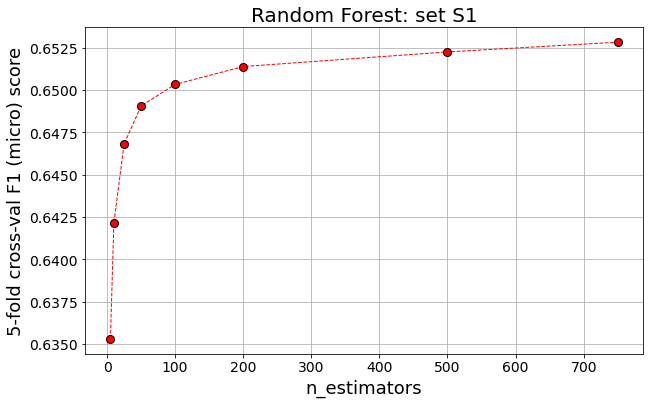

In [ ]:
plt.figure(figsize=(10,6))
plt.grid(zorder=0)
plt.plot(n_est, scores_nest, 'o--', color='red', markeredgecolor = 'k',  linewidth=1, markersize=8)
plt.xlabel(r'n_estimators',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('5-fold cross-val F1 (micro) score',fontsize=18)

plt.title(r'Random Forest: set S1',fontsize=20)

Max depth

In [ ]:
pipe = make_pipeline(RandomForestClassifier(n_estimators=200,random_state=2))

In [ ]:
max_d=[2,5,10,20,30,50,100]
param_grid = {'randomforestclassifier__max_depth': max_d}
clf = GridSearchCV(pipe, param_grid,  scoring= 'f1_micro' , cv=5)
clf.fit(X_train_subset_enc, Y_train.values.ravel())
scores_maxd=clf.cv_results_['mean_test_score']

Text(0.5, 1.0, 'Random Forest: set S1 ($n\\_estimators$=200)')

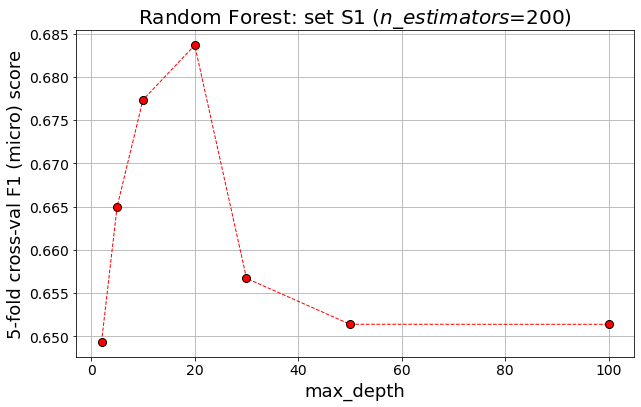

In [ ]:
plt.figure(figsize=(10,6))
plt.grid(zorder=0)
plt.plot(max_d, scores_maxd, 'o--', color='red', markeredgecolor = 'k',  linewidth=1, markersize=8)
plt.xlabel(r'max_depth',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('5-fold cross-val F1 (micro) score',fontsize=18)

plt.title(r'Random Forest: set S1 ($n\_estimators$=200)',fontsize=20)

Minimum samples split

In [ ]:
pipe = make_pipeline(RandomForestClassifier(n_estimators=200,max_depth=20,bootstrap=True,random_state=2))

In [ ]:
min_ss=[2,5,10,15,20]
param_grid = {'randomforestclassifier__min_samples_split': min_ss}
clf = GridSearchCV(pipe, param_grid,  scoring= 'f1_micro' , cv=5)
clf.fit(X_train_subset_enc, Y_train.values.ravel())
scores_min_ss=clf.cv_results_['mean_test_score']

Text(0.5, 1.0, 'Random Forest: set S1 ($n\\_estimators$=200, $max\\_depth$=20)')

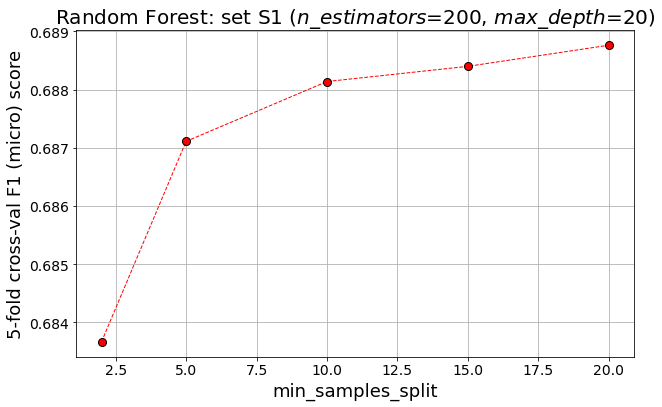

In [ ]:
plt.figure(figsize=(10,6))
plt.grid(zorder=0)
plt.plot(min_ss, scores_min_ss, 'o--', color='red', markeredgecolor = 'k',  linewidth=1, markersize=8)
plt.xlabel(r'min_samples_split',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('5-fold cross-val F1 (micro) score',fontsize=18)

plt.title(r'Random Forest: set S1 ($n\_estimators$=200, $max\_depth$=20)',fontsize=20)

Bootstrap

In [ ]:
pipe = make_pipeline(RandomForestClassifier(n_estimators=200,max_depth=20,min_samples_split=10,criterion='gini',random_state=2))

In [ ]:
boot=[True,False]
param_grid = {'randomforestclassifier__bootstrap': boot}
clf = GridSearchCV(pipe, param_grid,  scoring= 'f1_micro' , cv=5)
clf.fit(X_train_subset_enc, Y_train.values.ravel())
scores_crit=clf.cv_results_['mean_test_score']

In [ ]:
clf.best_params_

{'randomforestclassifier__bootstrap': True}

In [ ]:
clf.cv_results_['mean_test_score']

array([0.68814019, 0.68616014])

## Grid search

In [ ]:
pipe = make_pipeline(RandomForestClassifier(criterion='gini',random_state=2))

In [ ]:
n_est=[200,300,400,500]
max_d=[10,20,30,40]
min_ss=[5,8,10,12]

In [ ]:
param_grid = {'randomforestclassifier__n_estimators': n_est,'randomforestclassifier__max_depth': max_d,'randomforestclassifier__min_samples_split': min_ss}
clf = GridSearchCV(pipe, param_grid,  scoring= 'f1_micro' , cv=5)
clf.fit(X_train_subset_enc, Y_train.values.ravel())

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('randomforestclassifier',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                           

In [ ]:
scores_gs=clf.cv_results_['mean_test_score']
scores_gs

array([0.676989  , 0.67719366, 0.676989  , 0.67695063, 0.67725122,
       0.67679074, 0.67682272, 0.67695063, 0.67690586, 0.67666922,
       0.67661806, 0.6767076 , 0.67682272, 0.67666283, 0.67662446,
       0.67665643, 0.68456766, 0.68527117, 0.68532233, 0.68530954,
       0.68627526, 0.68624328, 0.68627526, 0.68635201, 0.6864991 ,
       0.6866526 , 0.6866462 , 0.68676772, 0.68639678, 0.68711307,
       0.68709389, 0.68685086, 0.66666667, 0.66691609, 0.66688411,
       0.667044  , 0.67407265, 0.67410463, 0.67454592, 0.6744372 ,
       0.67673318, 0.67668202, 0.67695702, 0.67714249, 0.6785495 ,
       0.67885649, 0.67910591, 0.67909951, 0.66294449, 0.66346252,
       0.66367357, 0.66399335, 0.67237145, 0.67221796, 0.67256332,
       0.67253134, 0.67531977, 0.67501279, 0.67555641, 0.67559478,
       0.67737913, 0.67725122, 0.67764134, 0.67774367])

In [ ]:
clf.best_params_

{'randomforestclassifier__max_depth': 20,
 'randomforestclassifier__min_samples_split': 12,
 'randomforestclassifier__n_estimators': 300}

Los mejores parámetros son: 
{'randomforestclassifier__max_depth': 20,
 'randomforestclassifier__min_samples_split': 12,
 'randomforestclassifier__n_estimators': 300}

# Random Forest con los mejores parámetros

## set S1

In [ ]:
model = RandomForestClassifier(max_depth=20,min_samples_split=12,n_estimators=300,random_state=2)
rf_clf=model.fit(X_train_subset_enc, Y_train.values.ravel())
Y_pred = rf_clf.predict(X_val_subset_enc)

In [ ]:
f1_val=f1_score(Y_val, Y_pred, average='micro')
print('F1_val = ', f1_val)

F1_val =  0.687986370124787


[0.08581308 0.08910721 0.06368521 0.02906013 0.03505084 0.0190454
 0.00495789 0.00890596 0.13758277 0.15339288 0.16753994 0.00300487
 0.01902168 0.03976124 0.00560267 0.00646093 0.0105968  0.01013449
 0.01952855 0.01227226 0.00109635 0.03011173 0.00811796 0.00159269
 0.0085401  0.01467051 0.00771972 0.00762615]


Text(0.5, 1.0, 'Random Forest: set S1')

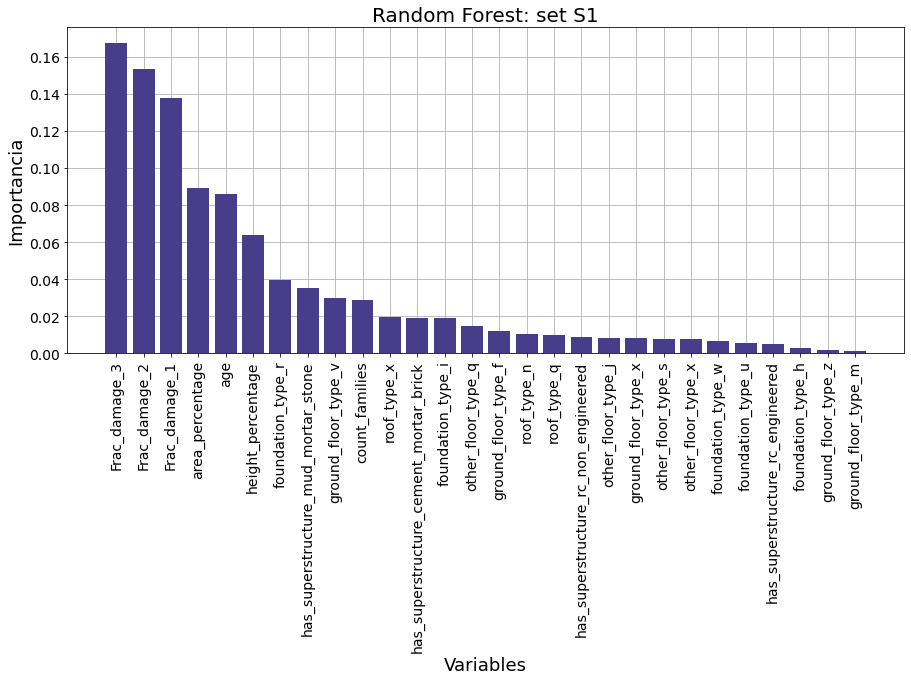

In [ ]:
print(model.feature_importances_)

cb_fi=pd.concat([pd.Series(X_train_subset_enc.columns),pd.Series(model.feature_importances_)],axis=1).set_index(0).sort_values([1],ascending=False).rename(columns={1:'Importance'})
cb_fi.index=cb_fi.index.set_names('Feature')

plt.figure(figsize=(15,6))
plt.grid(zorder=0)
plt.bar(cb_fi.index,cb_fi['Importance'],color='darkslateblue',zorder=3)
plt.xlabel("Variables",fontsize=18)
plt.ylabel("Importancia",fontsize=18)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'Random Forest: set S1',fontsize=20)

## S1 + land_surface_condition

In [ ]:
X_train_subset_enc_1=pd.get_dummies(X_train_subset_enc.merge(X_train['land_surface_condition'], left_index=True, right_index=True, how='inner'))
X_val_subset_enc_1=pd.get_dummies(X_val_subset_enc.merge(X_val['land_surface_condition'], left_index=True, right_index=True, how='inner'))

X_train_subset_enc_1.head()

,age,area_percentage,height_percentage,count_families,has_superstructure_mud_mortar_stone,has_superstructure_cement_mortar_brick,has_superstructure_rc_engineered,has_superstructure_rc_non_engineered,Frac_damage_1,Frac_damage_2,Frac_damage_3,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
984478,20,8,5,1,1,0,0,0,0.055985,0.549228,0.394788,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1
33931,20,6,9,1,1,0,0,0,0.021418,0.393584,0.584999,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1
599202,20,6,4,1,1,0,0,0,0.013241,0.179339,0.807420,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1
692573,20,12,6,0,1,0,0,0,0.021418,0.393584,0.584999,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1
719424,10,8,5,1,1,1,0,0,0.356327,0.556327,0.087345,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0


In [ ]:
model = RandomForestClassifier(max_depth=20,min_samples_split=12,n_estimators=300,random_state=2)
rf_clf=model.fit(X_train_subset_enc_1, Y_train.values.ravel())
Y_pred = rf_clf.predict(X_val_subset_enc_1)
f1_val=f1_score(Y_val, Y_pred, average='micro')
print('F1_val = ', f1_val)

F1_val =  0.6894752191063837


[0.07808297 0.08063796 0.05899571 0.02660608 0.03441535 0.01908966
 0.00475545 0.0089973  0.13096836 0.15609443 0.17549466 0.00302887
 0.0189324  0.03658081 0.0055746  0.00625872 0.01080557 0.00991608
 0.01948192 0.01254593 0.00106746 0.02965404 0.00783181 0.00151766
 0.00858985 0.01408769 0.00757168 0.00729112 0.00893018 0.00614753
 0.01004815]


Text(0.5, 1.0, 'Random Forest: set S1 + land_surface_condition')

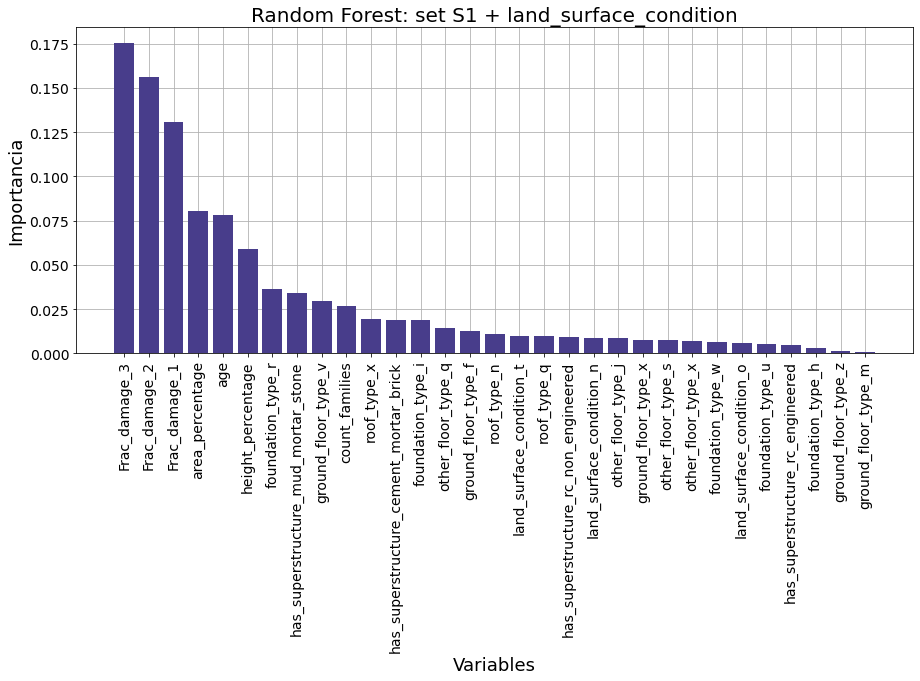

In [ ]:
print(model.feature_importances_)

cb_fi=pd.concat([pd.Series(X_train_subset_enc_1.columns),pd.Series(model.feature_importances_)],axis=1).set_index(0).sort_values([1],ascending=False).rename(columns={1:'Importance'})
cb_fi.index=cb_fi.index.set_names('Feature')

plt.figure(figsize=(15,6))
plt.grid(zorder=0)
plt.bar(cb_fi.index,cb_fi['Importance'],color='darkslateblue',zorder=3)
plt.xlabel("Variables",fontsize=18)
plt.ylabel("Importancia",fontsize=18)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'Random Forest: set S1 + land_surface_condition',fontsize=20)

## S1 + land_surface_condition + binarias restantes

In [ ]:
X_train_has=X_train[(X_train.filter(like='has_')).columns.tolist()]
X_train_has.drop(columns=(X_train_subset.filter(like='has_')).columns.tolist(),inplace=True)

X_val_has=X_val[(X_val.filter(like='has_')).columns.tolist()]
X_val_has.drop(columns=(X_val_subset.filter(like='has_')).columns.tolist(),inplace=True)

X_train_subset_enc_2=X_train_subset_enc_1.merge(X_train_has, left_index=True, right_index=True, how='inner')
X_val_subset_enc_2=X_val_subset_enc_1.merge(X_val_has, left_index=True, right_index=True, how='inner')

X_train_subset_enc_2.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,age,area_percentage,height_percentage,count_families,has_superstructure_mud_mortar_stone,has_superstructure_cement_mortar_brick,has_superstructure_rc_engineered,has_superstructure_rc_non_engineered,Frac_damage_1,Frac_damage_2,Frac_damage_3,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,has_superstructure_adobe_mud,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_other,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
984478,20,8,5,1,1,0,0,0,0.055985,0.549228,0.394788,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
33931,20,6,9,1,1,0,0,0,0.021418,0.393584,0.584999,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
599202,20,6,4,1,1,0,0,0,0.013241,0.179339,0.807420,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
692573,20,12,6,0,1,0,0,0,0.021418,0.393584,0.584999,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
719424,10,8,5,1,1,1,0,0,0.356327,0.556327,0.087345,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
model = RandomForestClassifier(max_depth=20,min_samples_split=12,n_estimators=300,random_state=2)
rf_clf=model.fit(X_train_subset_enc_2, Y_train.values.ravel())
Y_pred = rf_clf.predict(X_val_subset_enc_2)
f1_val=f1_score(Y_val, Y_pred, average='micro')
print('F1_val = ', f1_val)

F1_val =  0.697241792144403


[6.04546696e-02 5.81970157e-02 4.51111398e-02 1.98737365e-02
 3.21825359e-02 1.70011109e-02 4.87707147e-03 7.15802526e-03
 1.30109307e-01 1.53131470e-01 1.71396578e-01 2.32525119e-03
 1.60676474e-02 3.73596223e-02 5.15353198e-03 6.02356673e-03
 1.04435187e-02 9.67164855e-03 1.85628053e-02 1.25296307e-02
 8.39525716e-04 2.53268754e-02 7.15210309e-03 1.30809133e-03
 8.36101765e-03 1.44059064e-02 8.65334311e-03 7.52035683e-03
 8.12060914e-03 5.41879184e-03 9.24322647e-03 8.67908545e-03
 8.33392386e-03 5.18353145e-03 9.67632519e-03 1.45998274e-02
 7.95332232e-03 5.53792178e-03 9.12462608e-03 6.08391400e-03
 5.16609548e-03 2.14422934e-03 4.07072930e-04 2.27459717e-04
 6.55012565e-04 1.06971222e-04 6.65915081e-05 5.23584217e-05
 2.02200196e-03]


Text(0.5, 1.0, 'Random Forest: set S1 + land_surface_condition + binarias restantes')

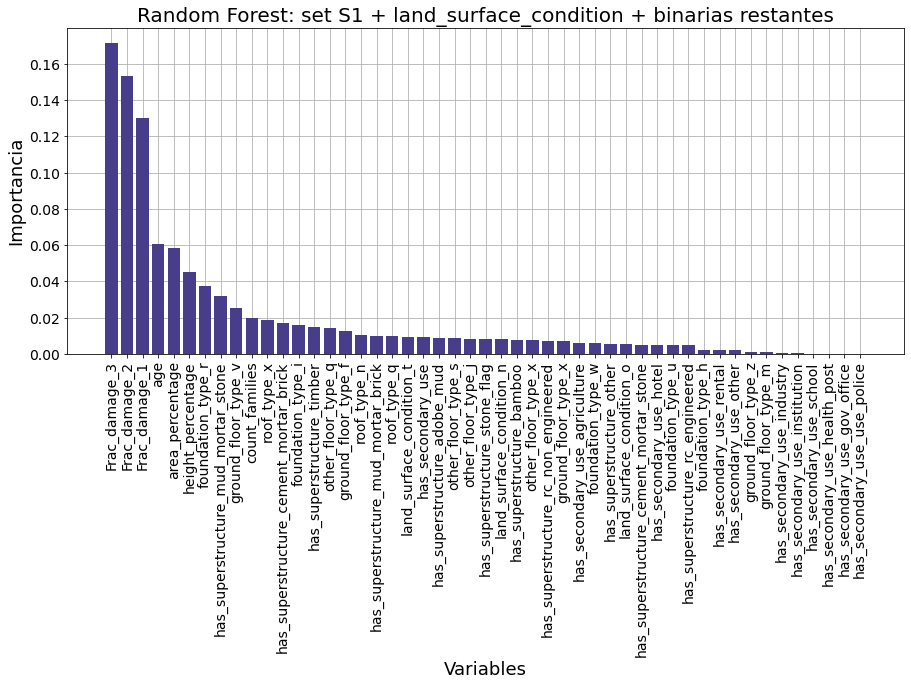

In [ ]:
print(model.feature_importances_)

cb_fi=pd.concat([pd.Series(X_train_subset_enc_2.columns),pd.Series(model.feature_importances_)],axis=1).set_index(0).sort_values([1],ascending=False).rename(columns={1:'Importance'})
cb_fi.index=cb_fi.index.set_names('Feature')

plt.figure(figsize=(15,6))
plt.grid(zorder=0)
plt.bar(cb_fi.index,cb_fi['Importance'],color='darkslateblue',zorder=3)
plt.xlabel("Variables",fontsize=18)
plt.ylabel("Importancia",fontsize=18)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'Random Forest: set S1 + land_surface_condition + binarias restantes',fontsize=20)

## set S2

In [ ]:
print(X_train.shape)
X_train_s2=X_train.merge(frac_df,how='left',left_on='geo_level_1_id',right_index=True).rename(columns={'1':'Frac_damage_1','2':'Frac_damage_2','3':'Frac_damage_3'})
X_train_s2=X_train_s2.drop(columns=['count_floors_pre_eq','geo_level_1_id','geo_level_2_id','geo_level_3_id'])
print(X_train_s2.shape)
X_train_s2=pd.get_dummies(X_train_s2)
print(X_train_s2.shape)
X_train_s2.head()

(195450, 38)
(195450, 37)
(195450, 67)


,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,Frac_damage_1,Frac_damage_2,Frac_damage_3,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
984478,20,8,5,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.055985,0.549228,0.394788,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
33931,20,6,9,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.021418,0.393584,0.584999,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
599202,20,6,4,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.013241,0.179339,0.807420,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
692573,20,12,6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.021418,0.393584,0.584999,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
719424,10,8,5,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.356327,0.556327,0.087345,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
print(X_val.shape)
X_val_s2=X_val.merge(frac_df,how='left',left_on='geo_level_1_id',right_index=True).rename(columns={'1':'Frac_damage_1','2':'Frac_damage_2','3':'Frac_damage_3'})
X_val_s2=X_val_s2.drop(columns=['count_floors_pre_eq','geo_level_1_id','geo_level_2_id','geo_level_3_id'])
print(X_val_s2.shape)
X_val_s2=pd.get_dummies(X_val_s2)
print(X_val_s2.shape)
X_val_s2.head()

(65151, 38)
(65151, 37)
(65151, 67)


,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,Frac_damage_1,Frac_damage_2,Frac_damage_3,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
624213,5,6,7,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.085429,0.665703,0.248868,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
393391,20,8,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.602151,0.397849,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
615537,30,3,6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.034225,0.448978,0.516797,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
351011,70,11,6,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.169021,0.747686,0.083293,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
638354,5,16,12,0,0,0,0,0,1,0,0,1,0,0,2,1,0,1,0,0,0,0,0,0,0,0,0.013241,0.179339,0.807420,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
model = RandomForestClassifier(max_depth=20,min_samples_split=12,n_estimators=300,random_state=2)
rf_clf=model.fit(X_train_s2, Y_train.values.ravel())
Y_pred = rf_clf.predict(X_val_s2)
f1_val=f1_score(Y_val, Y_pred, average='micro')
print('F1_val = ', f1_val)

F1_val =  0.6981013338245


[5.06836234e-02 4.66152001e-02 3.64913340e-02 7.48093974e-03
 3.08971235e-02 7.32677270e-03 4.52238038e-03 8.39247390e-03
 1.75055959e-02 1.20462331e-02 6.86124362e-03 6.72948159e-03
 5.60562727e-03 4.84453352e-03 1.61831227e-02 8.12371123e-03
 5.36926270e-03 4.40741606e-03 1.84242153e-03 3.46621156e-04
 2.07259105e-04 5.59021589e-04 8.70962223e-05 6.11011385e-05
 3.75233373e-05 1.71100052e-03 1.34323125e-01 1.47243642e-01
 1.79559022e-01 6.94970918e-03 4.58266095e-03 7.99695185e-03
 2.26918320e-03 1.58741639e-02 3.30022896e-02 4.79943767e-03
 7.12993900e-03 9.60718607e-03 9.20474478e-03 1.93885906e-02
 1.24169080e-02 6.99333830e-04 2.79807773e-02 6.55958636e-03
 1.17974553e-03 7.97280526e-03 1.39361699e-02 7.48458735e-03
 6.79075343e-03 4.99269712e-03 1.84091610e-03 7.85781508e-03
 6.39401927e-03 4.74701992e-04 4.31730989e-04 5.03924707e-03
 2.62139147e-05 1.29130205e-04 1.22444881e-04 3.19983257e-04
 4.17871054e-03 5.16817393e-04 3.34362283e-03 3.22254421e-03
 1.85846090e-03 4.870856

Text(0.5, 1.0, 'Random Forest: set S2')

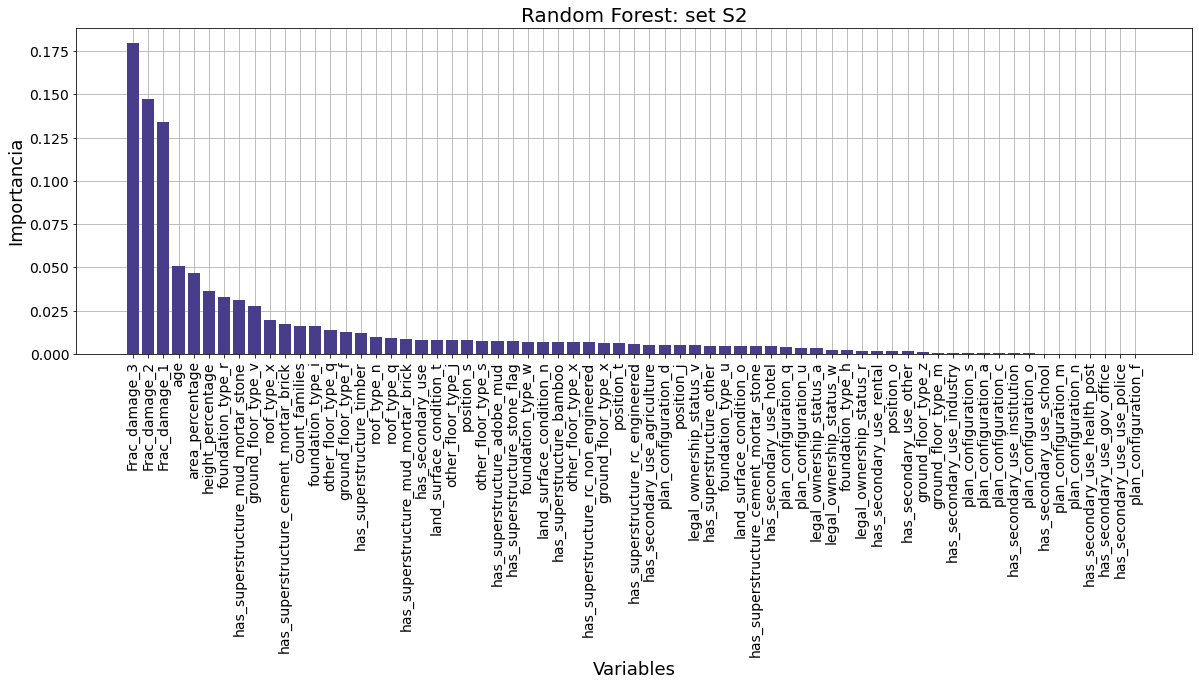

In [ ]:
print(model.feature_importances_)

cb_fi=pd.concat([pd.Series(X_train_s2.columns),pd.Series(model.feature_importances_)],axis=1).set_index(0).sort_values([1],ascending=False).rename(columns={1:'Importance'})
cb_fi.index=cb_fi.index.set_names('Feature')

plt.figure(figsize=(20,6))
plt.grid(zorder=0)
plt.bar(cb_fi.index,cb_fi['Importance'],color='darkslateblue',zorder=3)
plt.xlabel("Variables",fontsize=18)
plt.ylabel("Importancia",fontsize=18)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'Random Forest: set S2',fontsize=20)

## set S3

In [ ]:
print(X_train.shape)
X_train_s3=X_train.merge(frac_df,how='left',left_on='geo_level_1_id',right_index=True).rename(columns={'1':'Frac_damage_1','2':'Frac_damage_2','3':'Frac_damage_3'})
X_train_s3=X_train_s3.drop(columns=['geo_level_1_id','geo_level_2_id','geo_level_3_id'])
print(X_train_s3.shape)
X_train_s3=pd.get_dummies(X_train_s3)
print(X_train_s3.shape)
X_train_s3['Height_Area']=X_train_s3['height_percentage']/X_train_s3['area_percentage']
X_train_s3.head()

(195450, 38)
(195450, 38)
(195450, 68)


,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,Frac_damage_1,Frac_damage_2,Frac_damage_3,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w,Height_Area
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
984478,2,20,8,5,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.055985,0.549228,0.394788,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0.625000
33931,3,20,6,9,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.021418,0.393584,0.584999,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1.500000
599202,2,20,6,4,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.013241,0.179339,0.807420,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.666667
692573,3,20,12,6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.021418,0.393584,0.584999,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0.500000
719424,2,10,8,5,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.356327,0.556327,0.087345,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0.625000


In [ ]:
print(X_val.shape)
X_val_s3=X_val.merge(frac_df,how='left',left_on='geo_level_1_id',right_index=True).rename(columns={'1':'Frac_damage_1','2':'Frac_damage_2','3':'Frac_damage_3'})
X_val_s3=X_val_s3.drop(columns=['geo_level_1_id','geo_level_2_id','geo_level_3_id'])
print(X_val_s3.shape)
X_val_s3=pd.get_dummies(X_val_s3)
print(X_val_s3.shape)
X_val_s3['Height_Area']=X_val_s3['height_percentage']/X_val_s3['area_percentage']
X_val_s3.head()

(65151, 38)
(65151, 38)
(65151, 68)


,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,Frac_damage_1,Frac_damage_2,Frac_damage_3,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w,Height_Area
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
624213,2,5,6,7,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.085429,0.665703,0.248868,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1.166667
393391,2,20,8,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.602151,0.397849,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0.625000
615537,3,30,3,6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.034225,0.448978,0.516797,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,2.000000
351011,2,70,11,6,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.169021,0.747686,0.083293,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0.545455
638354,4,5,16,12,0,0,0,0,0,1,0,0,1,0,0,2,1,0,1,0,0,0,0,0,0,0,0,0.013241,0.179339,0.807420,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0.750000


In [ ]:
model = RandomForestClassifier(max_depth=20,min_samples_split=12,n_estimators=300,random_state=2)
rf_clf=model.fit(X_train_s3, Y_train.values.ravel())
Y_pred = rf_clf.predict(X_val_s3)
f1_val=f1_score(Y_val, Y_pred, average='micro')
print('F1_val = ', f1_val)

F1_val =  0.6989455265460238


[1.65436388e-02 4.75451812e-02 3.76286228e-02 3.01557379e-02
 6.99063163e-03 2.92176211e-02 6.71373196e-03 4.08613374e-03
 7.78523599e-03 1.64745222e-02 1.12467194e-02 6.25459380e-03
 5.82983198e-03 5.84692357e-03 4.40638451e-03 1.49504978e-02
 7.81492925e-03 5.19747296e-03 4.07907817e-03 1.70636820e-03
 3.02749967e-04 1.83986996e-04 4.89365545e-04 7.90503751e-05
 5.44097290e-05 3.90476736e-05 1.54100725e-03 1.30752178e-01
 1.45810676e-01 1.66840216e-01 6.61432284e-03 4.31332340e-03
 7.50304002e-03 2.07986391e-03 1.60274726e-02 3.06307148e-02
 4.64684209e-03 6.97723491e-03 9.08444614e-03 8.32535309e-03
 1.65068602e-02 1.16998169e-02 6.39363566e-04 2.76880461e-02
 6.63540694e-03 1.11605374e-03 6.08752678e-03 1.23094339e-02
 8.37056254e-03 6.37226285e-03 4.51241141e-03 1.41594195e-03
 7.33963726e-03 6.05820515e-03 4.20403658e-04 3.87746162e-04
 4.66704726e-03 2.62979049e-05 1.06114570e-04 1.13845978e-04
 2.81138667e-04 3.87966802e-03 4.47139705e-04 3.12097419e-03
 3.01805610e-03 1.655118

Text(0.5, 1.0, 'Random Forest: set S3')

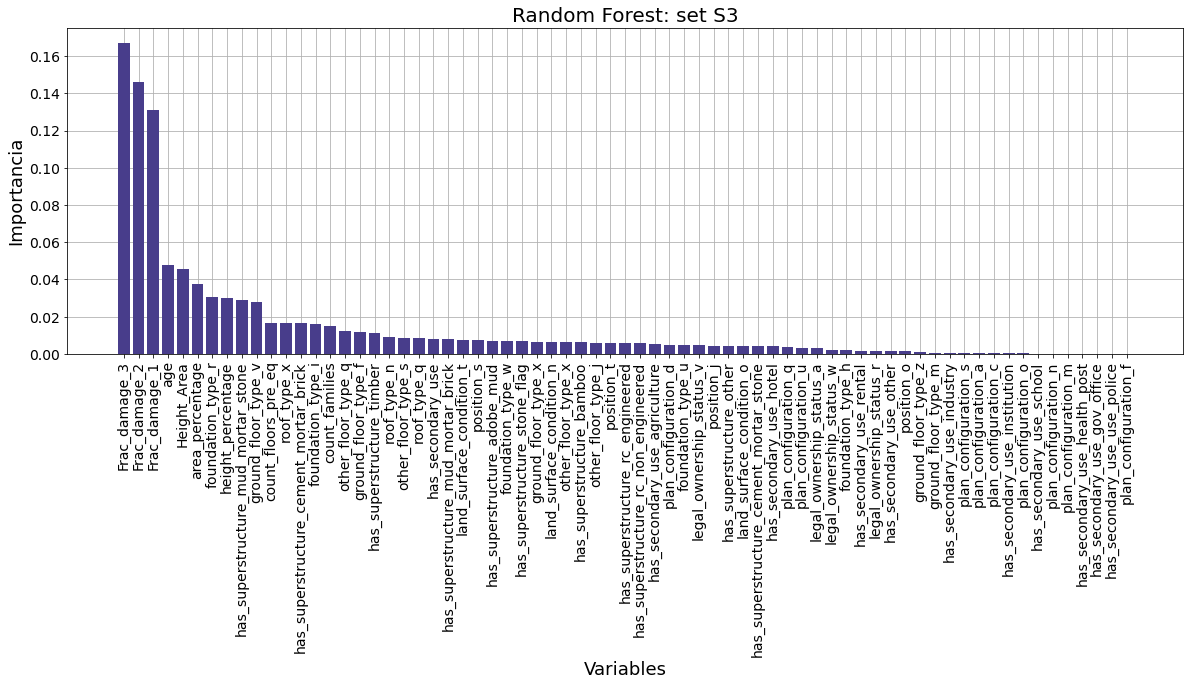

In [ ]:
print(model.feature_importances_)

cb_fi=pd.concat([pd.Series(X_train_s3.columns),pd.Series(model.feature_importances_)],axis=1).set_index(0).sort_values([1],ascending=False).rename(columns={1:'Importance'})
cb_fi.index=cb_fi.index.set_names('Feature')

plt.figure(figsize=(20,6))
plt.grid(zorder=0)
plt.bar(cb_fi.index,cb_fi['Importance'],color='darkslateblue',zorder=3)
plt.xlabel("Variables",fontsize=18)
plt.ylabel("Importancia",fontsize=18)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'Random Forest: set S3',fontsize=20)